# Filter viral barcodes in transcripts
This notebook filters viral barcodes in 10X transcriptome data to remove UMIs that are likely derived from leaked transcripts.

## Notebook setup
Import python modules:

In [1]:
from IPython.display import display

from dms_variants.constants import CBPALETTE

import kneed

import pandas as pd

import plotnine as p9

import scipy

import statsmodels.stats.multitest

Get `snakemake` variables [as described here](https://snakemake.readthedocs.io/en/stable/snakefiles/rules.html#jupyter-notebook-integration):

In [2]:
viral_tag_by_cell_csv = 'results/viral_tags_bcs_in_cells/scProgenyProduction_trial2_cell_barcodes_with_viral_tags.csv.gz'
viral_bc_by_cell_corrected_csv = 'results/viral_fastq10x/scProgenyProduction_trial2_viral_bc_by_cell_corrected.csv.gz'
expt = 'scProgenyProduction_trial2'
viral_bc_by_cell_filtered_csv = 'results/viral_fastq10x/scProgenyProduction_trial2_viral_bc_by_cell_filtered.csv.gz'
plot = 'results/viral_fastq10x/scProgenyProduction_trial2_viral_bc_by_cell_filtered.pdf'
fdr = 0.0001

## Organize data

Read the viral barcode UMI counts data into a pandas dataframe:

In [3]:
viral_bc_counts = pd.read_csv(viral_bc_by_cell_corrected_csv)
viral_bc_counts = (viral_bc_counts
                   .rename(columns={'count': 'bc_UMIs'}))
display(viral_bc_counts)

,cell_barcode,gene,viral_barcode,bc_UMIs
0,AAACCCAAGTAGGTTA,fluHA,ACGTTATTGATTGAGA,1
1,AAACCCAAGTAGGTTA,fluHA,AGAATCGACACATGTC,14
2,AAACCCAAGTAGGTTA,fluHA,AGCCATAGTCTAAAGG,8
3,AAACCCAAGTAGGTTA,fluHA,AGGATGATTTTTTTGT,5
4,AAACCCAAGTAGGTTA,fluHA,CACGGATGGTGTACGA,12
...,...,...,...,...
55238,TTTGTTGCATGTGGTT,fluNA,TTCCTCAGCCTTTAAG,3
55239,TTTGTTGTCTAGGAAA,fluNA,GAACCCGATGGGGAAT,26
55240,TTTGTTGTCTAGGAAA,fluNA,TAAGGTAAAATAATAG,1
55241,TTTGTTGTCTAGGAAA,fluNA,TAAGGTATAATTCTAG,4


Read the total number of UMIs per cell into a pandas dataframe. Only keep relevant columns.

In [4]:
all_cells = pd.read_csv(viral_tag_by_cell_csv)
all_cells = all_cells[['cell_barcode',
                       'infected',
                       'infecting_viral_tag',
                       'total_UMIs',
                       'viral_UMIs',
                       'cellular_UMIs',
                       'frac_viral_UMIs']]
display(all_cells)

,cell_barcode,infected,infecting_viral_tag,total_UMIs,viral_UMIs,cellular_UMIs,frac_viral_UMIs
0,AAACCCAAGTAGGTTA,True,syn,5367,3166,2201,0.589901
1,AAACCCACAAGGCCTC,True,syn,10304,1485,8819,0.144119
2,AAACCCACACACACGC,True,both,7395,3320,4075,0.448952
3,AAACCCATCGTGCATA,True,syn,2764,1597,1167,0.577786
4,AAACCCATCTACTGCC,False,none,6313,3,6310,0.000475
...,...,...,...,...,...,...,...
7436,TTTGGTTGTTAAGCAA,False,none,8528,29,8499,0.003401
7437,TTTGGTTTCGTCGCTT,False,none,6492,6,6486,0.000924
7438,TTTGTTGCATGTGGTT,True,wt,3016,1680,1336,0.557029
7439,TTTGTTGTCGTCGGGT,False,none,11070,2,11068,0.000181


Sanity check that `total_UMIs` is equal to `viral_UMIs + cellular_UMIs`:

In [5]:
assert bool((all_cells['total_UMIs'] ==
             all_cells['viral_UMIs'] +
             all_cells['cellular_UMIs'])
            .all()), "UMI counts do not add up"

Merge dataframes:

In [6]:
viral_bc_frac = pd.merge(left=viral_bc_counts,
                         right=all_cells,
                         how='outer',
                         on=['cell_barcode'])

# Make `infecting_viral_tag` column ordered category
viral_bc_frac['infecting_viral_tag'] = (viral_bc_frac['infecting_viral_tag']
                                        .astype('category')
                                        .cat
                                        .reorder_categories(['none',
                                                             'wt',
                                                             'syn',
                                                             'both']))

# Fill NaN values with meaningful description
viral_bc_frac['gene'] = viral_bc_frac['gene'].fillna('none')
viral_bc_frac['viral_barcode'] = viral_bc_frac['viral_barcode'].fillna('none')
viral_bc_frac['bc_UMIs'] = viral_bc_frac['bc_UMIs'].fillna(0)

display(viral_bc_frac)

,cell_barcode,gene,viral_barcode,bc_UMIs,infected,infecting_viral_tag,total_UMIs,viral_UMIs,cellular_UMIs,frac_viral_UMIs
0,AAACCCAAGTAGGTTA,fluHA,ACGTTATTGATTGAGA,1.0,True,syn,5367,3166,2201,0.589901
1,AAACCCAAGTAGGTTA,fluHA,AGAATCGACACATGTC,14.0,True,syn,5367,3166,2201,0.589901
2,AAACCCAAGTAGGTTA,fluHA,AGCCATAGTCTAAAGG,8.0,True,syn,5367,3166,2201,0.589901
3,AAACCCAAGTAGGTTA,fluHA,AGGATGATTTTTTTGT,5.0,True,syn,5367,3166,2201,0.589901
4,AAACCCAAGTAGGTTA,fluHA,CACGGATGGTGTACGA,12.0,True,syn,5367,3166,2201,0.589901
...,...,...,...,...,...,...,...,...,...,...
56311,TTTGATCGTGGAACCA,none,none,0.0,False,none,5128,6,5122,0.001170
56312,TTTGGTTAGTTTGGCT,none,none,0.0,False,none,4275,6,4269,0.001404
56313,TTTGGTTCACTGCGAC,none,none,0.0,True,wt,6835,910,5925,0.133138
56314,TTTGGTTTCGTCGCTT,none,none,0.0,False,none,6492,6,6486,0.000924


Sum total number of barcoded UMIs per cell:

In [7]:
viral_bc_frac = pd.merge(left=viral_bc_frac,
                         right=(viral_bc_frac
                                .groupby('cell_barcode')
                                ['bc_UMIs']
                                .sum()
                                .reset_index()
                                .rename(columns={'bc_UMIs':
                                                 'bc_UMIs_in_cell'})),
                         on=['cell_barcode'])

display(viral_bc_frac)

,cell_barcode,gene,viral_barcode,bc_UMIs,infected,infecting_viral_tag,total_UMIs,viral_UMIs,cellular_UMIs,frac_viral_UMIs,bc_UMIs_in_cell
0,AAACCCAAGTAGGTTA,fluHA,ACGTTATTGATTGAGA,1.0,True,syn,5367,3166,2201,0.589901,147.0
1,AAACCCAAGTAGGTTA,fluHA,AGAATCGACACATGTC,14.0,True,syn,5367,3166,2201,0.589901,147.0
2,AAACCCAAGTAGGTTA,fluHA,AGCCATAGTCTAAAGG,8.0,True,syn,5367,3166,2201,0.589901,147.0
3,AAACCCAAGTAGGTTA,fluHA,AGGATGATTTTTTTGT,5.0,True,syn,5367,3166,2201,0.589901,147.0
4,AAACCCAAGTAGGTTA,fluHA,CACGGATGGTGTACGA,12.0,True,syn,5367,3166,2201,0.589901,147.0
...,...,...,...,...,...,...,...,...,...,...,...
56311,TTTGATCGTGGAACCA,none,none,0.0,False,none,5128,6,5122,0.001170,0.0
56312,TTTGGTTAGTTTGGCT,none,none,0.0,False,none,4275,6,4269,0.001404,0.0
56313,TTTGGTTCACTGCGAC,none,none,0.0,True,wt,6835,910,5925,0.133138,0.0
56314,TTTGGTTTCGTCGCTT,none,none,0.0,False,none,6492,6,6486,0.000924,0.0


Calculate fraction of all UMIs and fraction of viral UMIs that have barcode.

In [8]:
viral_bc_frac['frac_total_UMIs_wBC'] = (viral_bc_frac['bc_UMIs_in_cell'] /
                                        viral_bc_frac['total_UMIs'])
viral_bc_frac['frac_viral_UMIs_wBC'] = (viral_bc_frac['bc_UMIs_in_cell'] /
                                        viral_bc_frac['viral_UMIs'])
display(viral_bc_frac)

,cell_barcode,gene,viral_barcode,bc_UMIs,infected,infecting_viral_tag,total_UMIs,viral_UMIs,cellular_UMIs,frac_viral_UMIs,bc_UMIs_in_cell,frac_total_UMIs_wBC,frac_viral_UMIs_wBC
0,AAACCCAAGTAGGTTA,fluHA,ACGTTATTGATTGAGA,1.0,True,syn,5367,3166,2201,0.589901,147.0,0.02739,0.046431
1,AAACCCAAGTAGGTTA,fluHA,AGAATCGACACATGTC,14.0,True,syn,5367,3166,2201,0.589901,147.0,0.02739,0.046431
2,AAACCCAAGTAGGTTA,fluHA,AGCCATAGTCTAAAGG,8.0,True,syn,5367,3166,2201,0.589901,147.0,0.02739,0.046431
3,AAACCCAAGTAGGTTA,fluHA,AGGATGATTTTTTTGT,5.0,True,syn,5367,3166,2201,0.589901,147.0,0.02739,0.046431
4,AAACCCAAGTAGGTTA,fluHA,CACGGATGGTGTACGA,12.0,True,syn,5367,3166,2201,0.589901,147.0,0.02739,0.046431
...,...,...,...,...,...,...,...,...,...,...,...,...,...
56311,TTTGATCGTGGAACCA,none,none,0.0,False,none,5128,6,5122,0.001170,0.0,0.00000,0.000000
56312,TTTGGTTAGTTTGGCT,none,none,0.0,False,none,4275,6,4269,0.001404,0.0,0.00000,0.000000
56313,TTTGGTTCACTGCGAC,none,none,0.0,True,wt,6835,910,5925,0.133138,0.0,0.00000,0.000000
56314,TTTGGTTTCGTCGCTT,none,none,0.0,False,none,6492,6,6486,0.000924,0.0,0.00000,0.000000


Calculate **each barcode's** fraction of all UMIs per cell:

In [9]:
viral_bc_frac['frac_bc_UMIs'] = (viral_bc_frac['bc_UMIs'] /
                                 viral_bc_frac['total_UMIs'])

display(viral_bc_frac)

,cell_barcode,gene,viral_barcode,bc_UMIs,infected,infecting_viral_tag,total_UMIs,viral_UMIs,cellular_UMIs,frac_viral_UMIs,bc_UMIs_in_cell,frac_total_UMIs_wBC,frac_viral_UMIs_wBC,frac_bc_UMIs
0,AAACCCAAGTAGGTTA,fluHA,ACGTTATTGATTGAGA,1.0,True,syn,5367,3166,2201,0.589901,147.0,0.02739,0.046431,0.000186
1,AAACCCAAGTAGGTTA,fluHA,AGAATCGACACATGTC,14.0,True,syn,5367,3166,2201,0.589901,147.0,0.02739,0.046431,0.002609
2,AAACCCAAGTAGGTTA,fluHA,AGCCATAGTCTAAAGG,8.0,True,syn,5367,3166,2201,0.589901,147.0,0.02739,0.046431,0.001491
3,AAACCCAAGTAGGTTA,fluHA,AGGATGATTTTTTTGT,5.0,True,syn,5367,3166,2201,0.589901,147.0,0.02739,0.046431,0.000932
4,AAACCCAAGTAGGTTA,fluHA,CACGGATGGTGTACGA,12.0,True,syn,5367,3166,2201,0.589901,147.0,0.02739,0.046431,0.002236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56311,TTTGATCGTGGAACCA,none,none,0.0,False,none,5128,6,5122,0.001170,0.0,0.00000,0.000000,0.000000
56312,TTTGGTTAGTTTGGCT,none,none,0.0,False,none,4275,6,4269,0.001404,0.0,0.00000,0.000000,0.000000
56313,TTTGGTTCACTGCGAC,none,none,0.0,True,wt,6835,910,5925,0.133138,0.0,0.00000,0.000000,0.000000
56314,TTTGGTTTCGTCGCTT,none,none,0.0,False,none,6492,6,6486,0.000924,0.0,0.00000,0.000000,0.000000


## Plots
Set base plot style:

In [10]:
p9.theme_set(p9.theme_classic())

### Per cell metrics
Summary figures that address number and fraction of barcoded viral UMIs **in aggregate for each cell**.

Plot number of viral barcode UMIs per cell and fraction of all UMIs with viral barcode per cell.

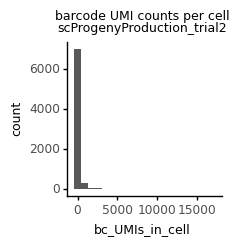

<ggplot: (8725961856250)>

In [11]:
fig = (p9.ggplot((viral_bc_frac
                  .groupby('cell_barcode')
                  .max()
                  .reset_index()), p9.aes(x='bc_UMIs_in_cell')) +
       p9.geom_histogram(bins=20) +
       p9.ggtitle('barcode UMI counts per cell\n'
                  f'{expt}') +
       p9.theme(figure_size=(2, 2),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

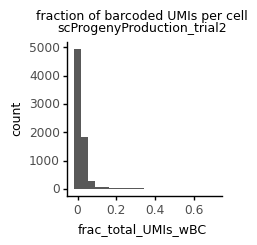

<ggplot: (8725961856338)>

In [12]:
fig = (p9.ggplot((viral_bc_frac
                  .groupby('cell_barcode')
                  .max()
                  .reset_index()), p9.aes(x='frac_total_UMIs_wBC')) +
       p9.geom_histogram(bins=20) +
       p9.ggtitle('fraction of barcoded UMIs per cell\n'
                  f'{expt}') +
       p9.theme(figure_size=(2, 2),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

Plot number of barcoded UMIs and fraction of barcoded UMIs per cell as a function of total UMI count:

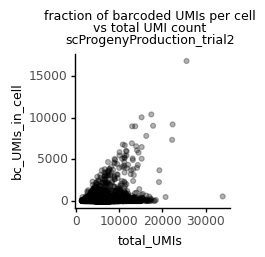

<ggplot: (8725961670976)>

In [13]:
fig = (p9.ggplot((viral_bc_frac
                  .groupby('cell_barcode')
                  .max()
                  .reset_index()), p9.aes(x='total_UMIs',
                                          y='bc_UMIs_in_cell')) +
       p9.geom_point(alpha=0.3) +
       p9.ggtitle('fraction of barcoded UMIs per cell\n'
                  'vs total UMI count\n'
                  f'{expt}') +
       p9.theme(figure_size=(2, 2),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

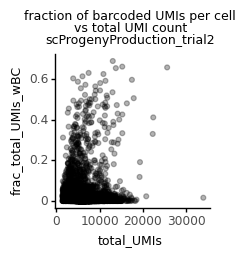

<ggplot: (8725963001817)>

In [14]:
fig = (p9.ggplot((viral_bc_frac
                  .groupby('cell_barcode')
                  .max()
                  .reset_index()), p9.aes(x='total_UMIs',
                                          y='frac_total_UMIs_wBC')) +
       p9.geom_point(alpha=0.3) +
       p9.ggtitle('fraction of barcoded UMIs per cell\n'
                  'vs total UMI count\n'
                  f'{expt}') +
       p9.theme(figure_size=(2, 2),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

Plot fraction of barcoded UMIs per cell as a function of viral UMI count and fraction:

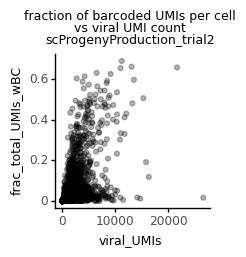

<ggplot: (8725958330384)>

In [15]:
fig = (p9.ggplot((viral_bc_frac
                  .groupby('cell_barcode')
                  .max()
                  .reset_index()), p9.aes(x='viral_UMIs',
                                          y='frac_total_UMIs_wBC')) +
       p9.geom_point(alpha=0.3) +
       p9.ggtitle('fraction of barcoded UMIs per cell\n'
                  'vs viral UMI count\n'
                  f'{expt}') +
       p9.theme(figure_size=(2, 2),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

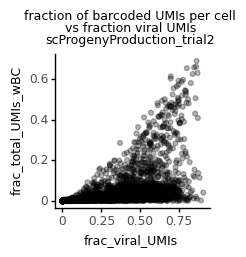

<ggplot: (8725958320918)>

In [16]:
fig = (p9.ggplot((viral_bc_frac
                  .groupby('cell_barcode')
                  .max()
                  .reset_index()), p9.aes(x='frac_viral_UMIs',
                                          y='frac_total_UMIs_wBC')) +
       p9.geom_point(alpha=0.3) +
       p9.ggtitle('fraction of barcoded UMIs per cell\n'
                  'vs fraction viral UMIs\n'
                  f'{expt}') +
       p9.theme(figure_size=(2, 2),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

Plot relationship between viral UMI fraction and fraction of viral UMIs with barcode:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_point : Removed 17 rows containing missing values.


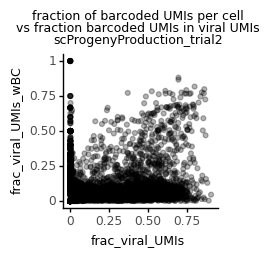

<ggplot: (8725958300275)>

In [17]:
fig = (p9.ggplot((viral_bc_frac
                  .groupby('cell_barcode')
                  .max()
                  .reset_index()), p9.aes(x='frac_viral_UMIs',
                                          y='frac_viral_UMIs_wBC')) +
       p9.geom_point(alpha=0.3) +
       p9.ggtitle('fraction of barcoded UMIs per cell\n'
                  'vs fraction barcoded UMIs in viral UMIs\n'
                  f'{expt}') +
       p9.theme(figure_size=(2, 2),
                plot_title=p9.element_text(size=9),
                axis_title=p9.element_text(size=9),
                legend_title=p9.element_text(size=9),
                legend_title_align='center'))
display(fig)

### Per barcode metrics
Figures that show the outcomes **for each barcode individually.**

Plot distribution of each barcode's fraction of a cell's total UMIs.

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/plotnine/layer.py:467: PlotnineWarning: geom_histogram : Removed 533 rows containing missing values.


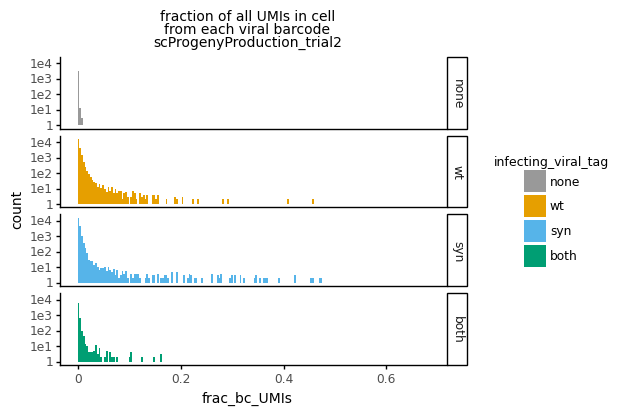

<ggplot: (8725957839071)>

In [18]:
fig = (p9.ggplot(viral_bc_frac, p9.aes(x='frac_bc_UMIs',
                                       fill='infecting_viral_tag')) +
       p9.geom_histogram(bins=200, position='stack') +
       p9.facet_grid('infecting_viral_tag~') +
       p9.ggtitle('fraction of all UMIs in cell\n'
                  'from each viral barcode\n'
                  f'{expt}') +
       p9.scale_y_log10() +
       p9.theme(figure_size=(5,
                             1*viral_bc_frac['infecting_viral_tag'].nunique()),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_fill_manual(CBPALETTE[0:]))
display(fig)

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


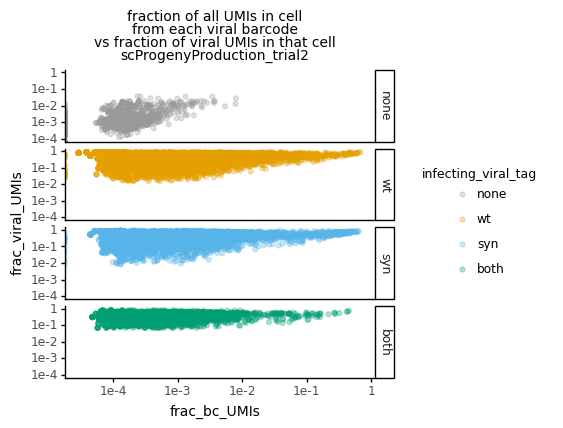

<ggplot: (8725957598070)>

In [19]:
fig = (p9.ggplot(viral_bc_frac, p9.aes(x='frac_bc_UMIs',
                                       y='frac_viral_UMIs',
                                       color='infecting_viral_tag')) +
       p9.geom_point(alpha=0.3) +
       p9.facet_grid('infecting_viral_tag~') +
       p9.ggtitle('fraction of all UMIs in cell\n'
                  'from each viral barcode\n'
                  'vs fraction of viral UMIs in that cell\n'
                  f'{expt}') +
       p9.scale_y_log10() +
       p9.scale_x_log10() +
       p9.theme(figure_size=(4,
                             2*viral_bc_frac['infected'].nunique()),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(CBPALETTE[0:]))
display(fig)

### Statistical test; uninfected cells as null distribution
I want to perform a statistical test for each barcode to see if I can reject the null hypothesis that it fits the distribution of barcode UMI counts observed in uninfected cells. All barcodes in uninfected cells should be derived from leaked transcripts.

I will assume that barcode counts in uninfected cells are poisson distributed. Since poisson calculations assume discrete numbers of outcomes, I will work with counts rather than fractions. 

For comparison, I will also calculate the number of UMI counts per barcode expected in each uninfected cell by multiplying the mean `frac_bc_UMIs` by the total number of UMIs in that that. cell.

Finally, I will generate a random sample of values pulled from a poisson distribution with the same mean.

I will plot the observed distribution, the distribution generated by multiplying frac_bc_UMIs * total_UMIs, and the poisson distributiong.

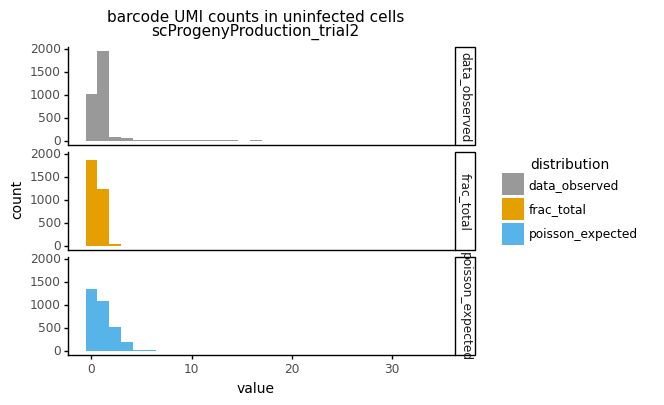

<ggplot: (8725961885510)>

In [20]:
# Calculate mean of barcode UMIs in uninfected cells
uninfected_mean = (viral_bc_frac
                   .query('infecting_viral_tag == "none"')
                   ['bc_UMIs']
                   .mean())

uninfected_frac_mean = (viral_bc_frac
                        .query('infecting_viral_tag == "none"')
                        ['frac_bc_UMIs']
                        .mean())

# Build dataframe with observed and random values
# generated from poisson distrubition with same mean
observed_series = (viral_bc_frac
                   .query('infecting_viral_tag == "none"')
                   ['bc_UMIs']
                   .rename('data_observed')
                   .astype(int)
                   .reset_index(drop=True))

frac_total_series = ((viral_bc_frac
                      .query('infecting_viral_tag == "none"')
                      ['total_UMIs'] *
                      uninfected_frac_mean)
                     .rename('frac_total')
                     .astype(int)
                     .reset_index(drop=True))

poisson_expected_series = (pd.Series(scipy
                                     .stats
                                     .poisson
                                     .rvs(mu = uninfected_mean,
                                          size=len(observed_series)))
                           .rename('poisson_expected')
                           .reset_index(drop=True))

poisson_check_df = (pd.concat([observed_series,
                               frac_total_series,
                               poisson_expected_series],
                             axis=1)
                    .melt(var_name='distribution'))


fig = (p9.ggplot(poisson_check_df,
                 p9.aes(x='value',
                        fill='distribution')) +
       p9.geom_histogram(bins=30) +
       p9.facet_grid('distribution~') +
       p9.ggtitle('barcode UMI counts in uninfected cells\n'
                  f'{expt}') +
       p9.theme(figure_size=(5, 4),
                plot_title=p9.element_text(size=11),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center') +
       p9.scale_fill_manual(CBPALETTE[0:]))
display(fig)

Next, I will do the statistical test for each barcode to see if it falls with in the poisson distribution with mu = mean `bc_UMIs` value.

I will adjust the probability for multiple tests using a false discovery rate of 0.0001.

In [21]:
viral_bc_frac['uninfected_P'] = (1 -
                                 scipy.stats.poisson.cdf(
                                      k=viral_bc_frac['bc_UMIs'],
                                      mu=uninfected_mean)
                                 )

viral_bc_frac['uninfected_Q'] = (statsmodels.stats.multitest.fdrcorrection(
                                 pvals=viral_bc_frac['uninfected_P'],
                                 alpha=fdr,
                                 method='indep',
                                 is_sorted=False,
                                 )[1])

                                 
viral_bc_frac['reject_uninfected'] = (viral_bc_frac['uninfected_Q'] < fdr)

display(viral_bc_frac)

,cell_barcode,gene,viral_barcode,bc_UMIs,infected,infecting_viral_tag,total_UMIs,viral_UMIs,cellular_UMIs,frac_viral_UMIs,bc_UMIs_in_cell,frac_total_UMIs_wBC,frac_viral_UMIs_wBC,frac_bc_UMIs,uninfected_P,uninfected_Q,reject_uninfected
0,AAACCCAAGTAGGTTA,fluHA,ACGTTATTGATTGAGA,1.0,True,syn,5367,3166,2201,0.589901,147.0,0.02739,0.046431,0.000186,2.263240e-01,2.307200e-01,False
1,AAACCCAAGTAGGTTA,fluHA,AGAATCGACACATGTC,14.0,True,syn,5367,3166,2201,0.589901,147.0,0.02739,0.046431,0.002609,6.439294e-14,3.771165e-13,True
2,AAACCCAAGTAGGTTA,fluHA,AGCCATAGTCTAAAGG,8.0,True,syn,5367,3166,2201,0.589901,147.0,0.02739,0.046431,0.001491,4.626035e-07,1.640759e-06,True
3,AAACCCAAGTAGGTTA,fluHA,AGGATGATTTTTTTGT,5.0,True,syn,5367,3166,2201,0.589901,147.0,0.02739,0.046431,0.000932,3.370160e-04,8.652167e-04,False
4,AAACCCAAGTAGGTTA,fluHA,CACGGATGGTGTACGA,12.0,True,syn,5367,3166,2201,0.589901,147.0,0.02739,0.046431,0.002236,1.696432e-11,8.478546e-11,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56311,TTTGATCGTGGAACCA,none,none,0.0,False,none,5128,6,5122,0.001170,0.0,0.00000,0.000000,0.000000,5.921017e-01,5.921017e-01,False
56312,TTTGGTTAGTTTGGCT,none,none,0.0,False,none,4275,6,4269,0.001404,0.0,0.00000,0.000000,0.000000,5.921017e-01,5.921017e-01,False
56313,TTTGGTTCACTGCGAC,none,none,0.0,True,wt,6835,910,5925,0.133138,0.0,0.00000,0.000000,0.000000,5.921017e-01,5.921017e-01,False
56314,TTTGGTTTCGTCGCTT,none,none,0.0,False,none,6492,6,6486,0.000924,0.0,0.00000,0.000000,0.000000,5.921017e-01,5.921017e-01,False


Plot P values and Q values for each barcode:

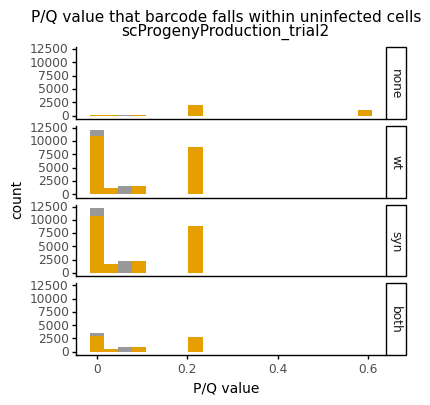

<ggplot: (8725958334525)>

In [22]:
fig = (p9.ggplot(viral_bc_frac) +
       p9.geom_histogram(p9.aes(x='uninfected_P'), fill=CBPALETTE[0], bins=20) +
       p9.geom_histogram(p9.aes(x='uninfected_Q'), fill=CBPALETTE[1], bins=20) +
       p9.facet_grid('infecting_viral_tag~') +
       p9.ggtitle('P/Q value that barcode falls within uninfected cells\n'
                  f'{expt}') +
       p9.xlab('P/Q value') +
       p9.theme(figure_size=(4, 4),
                plot_title=p9.element_text(size=11),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=10),
                legend_title_align='center'))
display(fig)

Plot number of viral barcodes where null distribution was rejected:

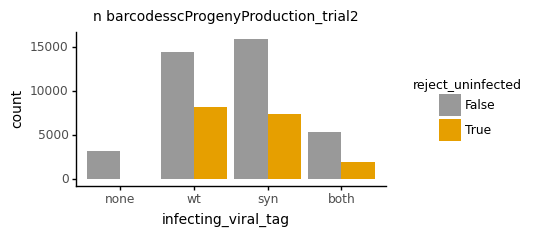

<ggplot: (8725957853486)>

In [23]:
fig = (p9.ggplot(viral_bc_frac, p9.aes(x='infecting_viral_tag',
                                       fill='reject_uninfected')) +
       p9.geom_bar(stat='count', position = 'dodge') +
       p9.ggtitle('n barcodes'
                  f'{expt}') +
       p9.theme(figure_size=(4,2),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_fill_manual(CBPALETTE[0:]))
display(fig)

Plot relationship between frac_bc_UMIs and Q value:

/fh/fast/bloom_j/software/miniconda3/envs/barcoded_flu_pdmH1N1/lib/python3.8/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10


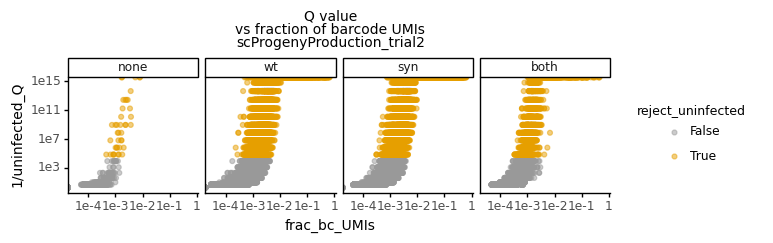

<ggplot: (8725958334534)>

In [24]:
fig = (p9.ggplot(viral_bc_frac, p9.aes(x='frac_bc_UMIs',
                                       y='1/uninfected_Q',
                                       color='reject_uninfected')) +
       p9.geom_point(alpha=0.5) +
       p9.facet_grid('~infecting_viral_tag') +
       p9.ggtitle('Q value\n'
                  'vs fraction of barcode UMIs\n'
                  f'{expt}') +
       p9.scale_y_log10() +
       p9.scale_x_log10() +
       p9.theme(figure_size=(7,1.5),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(CBPALETTE[0:]))
display(fig)

### Knee plots

Rank order barcodes by fraction of total UMIs in their cell:

In [25]:
viral_bc_frac = (viral_bc_frac
                 .sort_values('frac_bc_UMIs', ascending=True)
                 .reset_index(drop=True))

viral_bc_frac = (viral_bc_frac
                 .assign(bc_rank=lambda x: (x['frac_bc_UMIs']
                                            .rank(method='first',
                                                  ascending=True))))

display(viral_bc_frac)

,cell_barcode,gene,viral_barcode,bc_UMIs,infected,infecting_viral_tag,total_UMIs,viral_UMIs,cellular_UMIs,frac_viral_UMIs,bc_UMIs_in_cell,frac_total_UMIs_wBC,frac_viral_UMIs_wBC,frac_bc_UMIs,uninfected_P,uninfected_Q,reject_uninfected,bc_rank
0,TTTGTTGTCGTCGGGT,none,none,0.0,False,none,11070,2,11068,0.000181,0.0,0.000000,0.000000,0.000000,0.592102,0.592102,False,1.0
1,CGGAATTTCACTACGA,none,none,0.0,False,none,5085,3,5082,0.000590,0.0,0.000000,0.000000,0.000000,0.592102,0.592102,False,2.0
2,CGGAATTTCCCTTGTG,none,none,0.0,False,none,6115,4,6111,0.000654,0.0,0.000000,0.000000,0.000000,0.592102,0.592102,False,3.0
3,CGGACACAGTTCACTG,none,none,0.0,False,none,5474,10,5464,0.001827,0.0,0.000000,0.000000,0.000000,0.592102,0.592102,False,4.0
4,CGGACACAGTTGCGCC,none,none,0.0,False,none,4875,8,4867,0.001641,0.0,0.000000,0.000000,0.000000,0.592102,0.592102,False,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56311,TAGGTACAGGCTAAAT,fluHA,AGGATTCATATATAGG,6704.0,True,wt,10864,9097,1767,0.837353,6786.0,0.624632,0.745960,0.617084,0.000000,0.000000,True,56312.0
56312,TCCTCTTTCTTTGCTA,fluHA,TTTCGGTTGATTATTG,4606.0,True,syn,7441,6461,980,0.868297,4688.0,0.630023,0.725584,0.619003,0.000000,0.000000,True,56313.0
56313,TAGGGTTGTAGAGCTG,fluHA,AGTTCTAAGGGAAGAC,8842.0,True,syn,13731,10979,2752,0.799578,8974.0,0.653558,0.817379,0.643944,0.000000,0.000000,True,56314.0
56314,GAAACCTGTACCGCGT,fluHA,TTGTTCAAATTTAGAG,9887.0,True,wt,15211,13072,2139,0.859378,10053.0,0.660903,0.769048,0.649990,0.000000,0.000000,True,56315.0


Calculate knee using [kneed](https://pypi.org/project/kneed/) package:

In [26]:
kl = kneed.KneeLocator(x=viral_bc_frac['bc_rank'].tolist(),
                       y=viral_bc_frac['frac_bc_UMIs'].tolist(),
                       curve='convex',
                       direction='increasing',
                       S=10
                       )

viral_bc_frac['above_knee'] = viral_bc_frac['frac_bc_UMIs'] >= kl.knee_y

display(viral_bc_frac)

print(f'knee rank: {kl.knee}')
print(f'fraction of total UMIs at knee point: {kl.knee_y}')
print(f'barcodes above knee: {len(viral_bc_frac.query("above_knee == True"))}')

,cell_barcode,gene,viral_barcode,bc_UMIs,infected,infecting_viral_tag,total_UMIs,viral_UMIs,cellular_UMIs,frac_viral_UMIs,bc_UMIs_in_cell,frac_total_UMIs_wBC,frac_viral_UMIs_wBC,frac_bc_UMIs,uninfected_P,uninfected_Q,reject_uninfected,bc_rank,above_knee
0,TTTGTTGTCGTCGGGT,none,none,0.0,False,none,11070,2,11068,0.000181,0.0,0.000000,0.000000,0.000000,0.592102,0.592102,False,1.0,False
1,CGGAATTTCACTACGA,none,none,0.0,False,none,5085,3,5082,0.000590,0.0,0.000000,0.000000,0.000000,0.592102,0.592102,False,2.0,False
2,CGGAATTTCCCTTGTG,none,none,0.0,False,none,6115,4,6111,0.000654,0.0,0.000000,0.000000,0.000000,0.592102,0.592102,False,3.0,False
3,CGGACACAGTTCACTG,none,none,0.0,False,none,5474,10,5464,0.001827,0.0,0.000000,0.000000,0.000000,0.592102,0.592102,False,4.0,False
4,CGGACACAGTTGCGCC,none,none,0.0,False,none,4875,8,4867,0.001641,0.0,0.000000,0.000000,0.000000,0.592102,0.592102,False,5.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56311,TAGGTACAGGCTAAAT,fluHA,AGGATTCATATATAGG,6704.0,True,wt,10864,9097,1767,0.837353,6786.0,0.624632,0.745960,0.617084,0.000000,0.000000,True,56312.0,True
56312,TCCTCTTTCTTTGCTA,fluHA,TTTCGGTTGATTATTG,4606.0,True,syn,7441,6461,980,0.868297,4688.0,0.630023,0.725584,0.619003,0.000000,0.000000,True,56313.0,True
56313,TAGGGTTGTAGAGCTG,fluHA,AGTTCTAAGGGAAGAC,8842.0,True,syn,13731,10979,2752,0.799578,8974.0,0.653558,0.817379,0.643944,0.000000,0.000000,True,56314.0,True
56314,GAAACCTGTACCGCGT,fluHA,TTGTTCAAATTTAGAG,9887.0,True,wt,15211,13072,2139,0.859378,10053.0,0.660903,0.769048,0.649990,0.000000,0.000000,True,56315.0,True


knee rank: 54940.0
fraction of total UMIs at knee point: 0.013979496738117428
barcodes above knee: 1377


Plot knee plot of each barcode's fraction of all UMIs in cell:

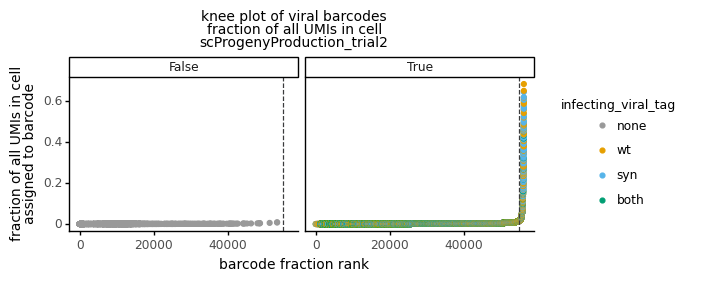

<ggplot: (8725961912543)>

In [27]:
fig = (p9.ggplot(viral_bc_frac, p9.aes(x='bc_rank',
                                       y='frac_bc_UMIs',
                                       color='infecting_viral_tag')) +
       p9.geom_point() +
       p9.geom_vline(xintercept=kl.knee,
                     linetype='dashed',
                     color='#3A3B3C',
                     size=0.5) +
       p9.facet_grid('~infected') +
       p9.ggtitle('knee plot of viral barcodes\n'
                  'fraction of all UMIs in cell\n'
                  f'{expt}') +
       p9.xlab('barcode fraction rank') +
       p9.ylab('fraction of all UMIs in cell\n'
               'assigned to barcode') +
       p9.theme(figure_size=(6, 2),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(CBPALETTE[0:]))

display(fig)

Break the plot out by infecting viral tag and viral gene:

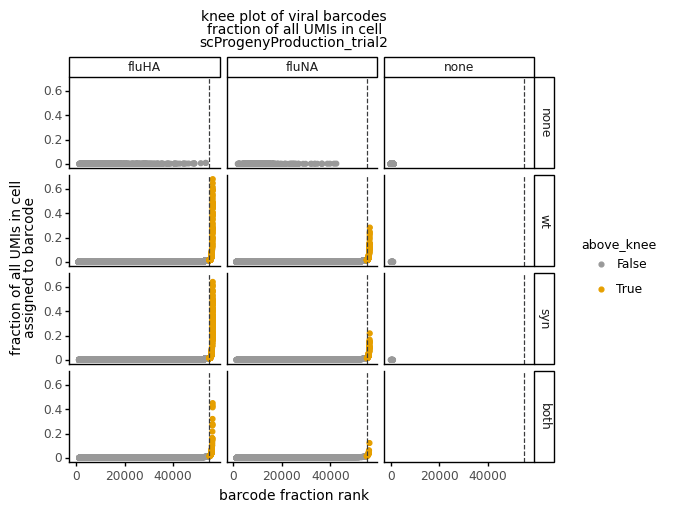

<ggplot: (8725961663687)>

In [28]:
fig = (p9.ggplot(viral_bc_frac, p9.aes(x='bc_rank',
                                       y='frac_bc_UMIs',
                                       color='above_knee')) +
       p9.geom_point() +
       p9.geom_vline(xintercept=kl.knee,
                     linetype='dashed',
                     color='#3A3B3C',
                     size=0.5) +
       p9.facet_grid('infecting_viral_tag~gene') +
       p9.ggtitle('knee plot of viral barcodes\n'
                  'fraction of all UMIs in cell\n'
                  f'{expt}') +
       p9.xlab('barcode fraction rank') +
       p9.ylab('fraction of all UMIs in cell\n'
               'assigned to barcode') +
       p9.theme(figure_size=(6, 5),
                plot_title=p9.element_text(size=10),
                axis_title=p9.element_text(size=10),
                legend_title=p9.element_text(size=9),
                legend_title_align='center') +
       p9.scale_color_manual(CBPALETTE[0:]))

display(fig)

In [29]:
#  Temporary cell to create files expected by snakemake.
#  Not final version

print(f"Saving plots to {plot}")
p9.ggsave(plot=fig, filename=plot, verbose=False)

print(f"Saving filtered barcodes to {viral_bc_by_cell_filtered_csv}")
viral_bc_frac = (viral_bc_frac
                 .query('viral_barcode != "none"')
                 [['cell_barcode',
                   'gene',
                   'frac_bc_UMIs']]
                 .drop_duplicates()
                 .rename(columns={'mean_freq_corrected_bc':
                                  'freq'}))


viral_bc_frac.to_csv(viral_bc_by_cell_filtered_csv,
                     columns=['cell_barcode',
                              'gene',
                              'frac_bc_UMIs'],
                     index=False)

Saving plots to results/viral_fastq10x/scProgenyProduction_trial2_viral_bc_by_cell_filtered.pdf
Saving filtered barcodes to results/viral_fastq10x/scProgenyProduction_trial2_viral_bc_by_cell_filtered.csv.gz


### 